In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
!python3 -m pip install kaggle --upgrade

In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle

In [95]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
! chmod 600 /root/.kaggle/kaggle.json

In [0]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}
! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [0]:
! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [99]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1,
                      max_zoom=1.05, max_warp=0)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
       .databunch()
       .normalize(imagenet_stats))

In [0]:
acc_2 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [0]:
arch = models.resnet50

In [0]:
learn = cnn_learner(data, arch, metrics=[acc_2, f_score])

In [0]:
learn_2 = cnn_learner(data, arch, metrics=[acc_2, f_score])

In [106]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [0]:
# In case you want to fit the misclassified data:
# use lear.unfreeze()
# learn.data= new_dat_bunch
# learn.fit_one_cycle(num_epochs)

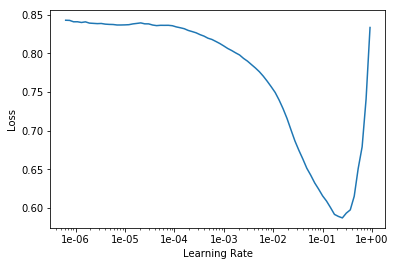

In [107]:
learn.recorder.plot()

In [108]:
lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.125413,0.111473,0.947557,0.901810,02:33
1,0.111240,0.096138,0.951103,0.916964,02:35
2,0.102902,0.093204,0.955543,0.917691,02:34
3,0.095959,0.094912,0.954445,0.924594,02:35
4,0.093537,0.086486,0.957425,0.926121,02:34


In [133]:
# max_lr = slice(1e-1/2, 1) --> This learning rate is too high
# max_lr = slice(1e-2, 1e-1) --> This is somewhat hight
# max_lr = slice(1e-1) --> lr somewhat high
# learn_2.fit_one_cycle(5) 
learn_2.fit_one_cycle(5, max_lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.169022,0.147948,0.947491,0.884389,02:45
1,0.176972,0.145543,0.942848,0.888400,02:46
2,0.138553,0.346949,0.937841,0.894403,02:46
3,0.111323,1.320260,0.954525,0.918315,02:48
4,0.097372,4.319881,0.955259,0.922091,02:47


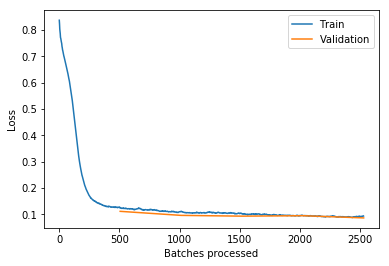

In [109]:
learn.recorder.learn.recorder.plot_losses()

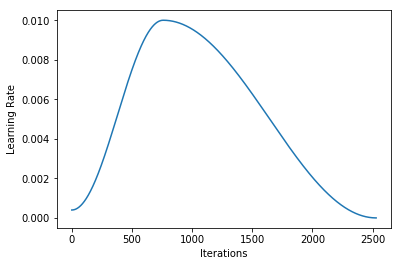

In [110]:
learn.recorder.plot_lr()

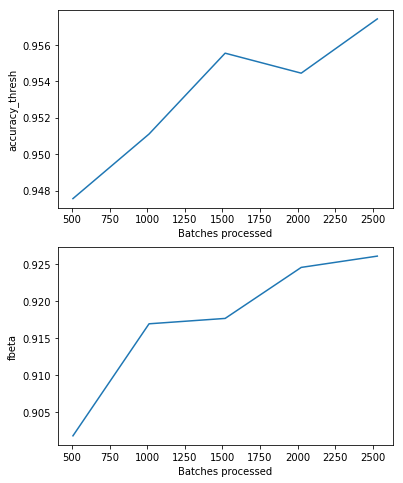

In [111]:
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-1-rs50')

Fine-tuning the model

In [0]:
learn.unfreeze()

In [114]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


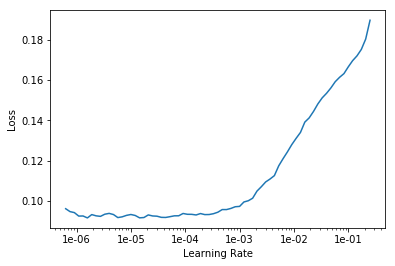

In [115]:
learn.recorder.plot()

In [116]:
learn.fit_one_cycle(5, slice(1e-5/9, lr/5)) # since least is a little ahead 1e-5, hence div by 9 not 10

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.091871,0.087388,0.956378,0.924304,02:51
1,0.093028,0.086463,0.957977,0.926569,02:50
2,0.089645,0.084811,0.956276,0.927325,02:49
3,0.082305,0.083694,0.959358,0.929756,02:48
4,0.080666,0.083160,0.959677,0.929428,02:50


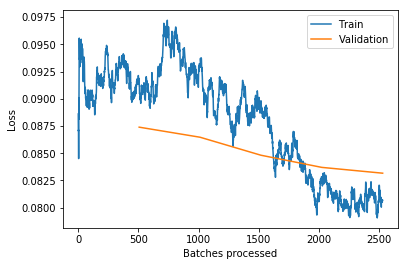

In [118]:
learn.recorder.plot_losses()

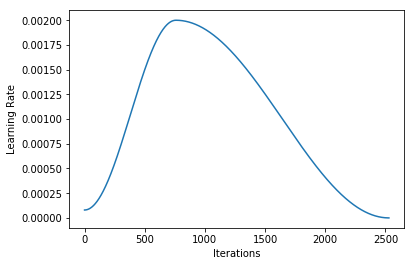

In [119]:
learn.recorder.plot_lr()

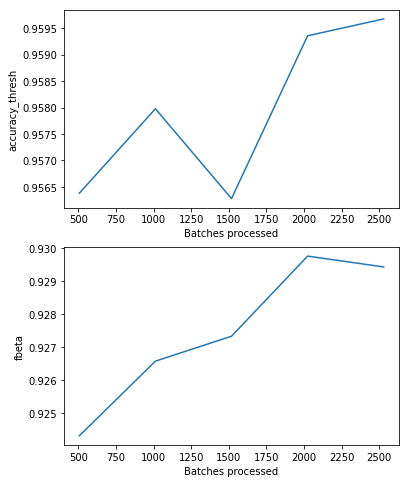

In [120]:
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-2-rs50-1')
# learn.load('stage-2-rs50-1')

In [0]:
data = (src.transform(tfms, size=256)
       .databunch()
       .normalize(imagenet_stats))
learn.data = data

In [0]:
learn.freeze()

In [137]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


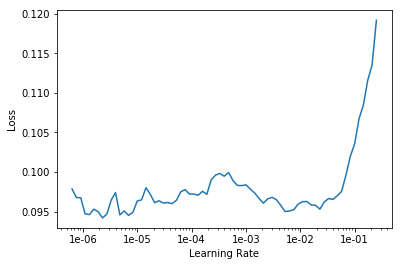

In [138]:
learn.recorder.plot()

In [139]:
lr = 1e-2/2 # increase in loss starts at A, then select A/10; here A = (1e-1)/2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.090158,0.093314,0.950899,0.916988,05:29
1,0.096455,0.094356,0.951270,0.916606,05:35
2,0.091038,0.084855,0.957468,0.926014,05:38
3,0.086294,0.082139,0.958006,0.928206,05:36
4,0.080161,0.081145,0.959765,0.930367,05:41


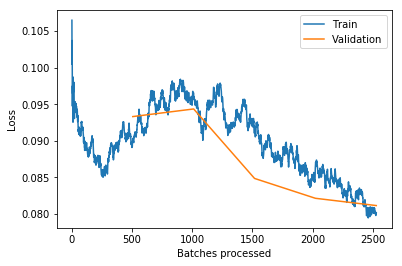

In [141]:
learn.recorder.plot_losses()

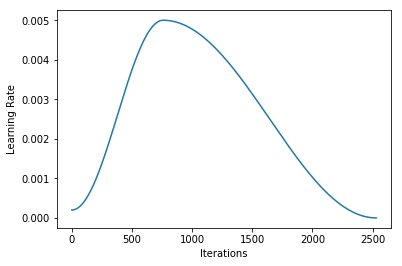

In [142]:
learn.recorder.plot_lr()

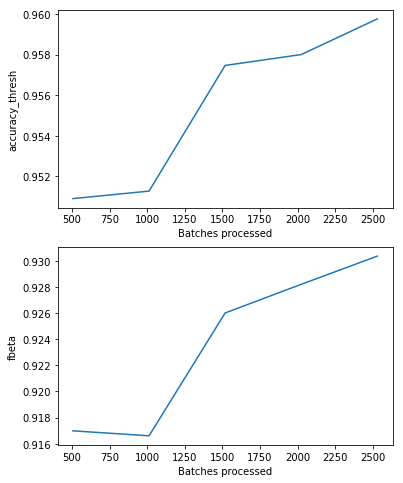

In [143]:
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-1-256-rs50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


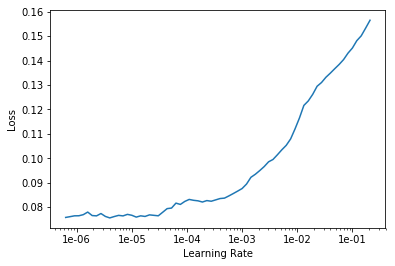

In [146]:
learn.lr_find()
learn.recorder.plot()

In [148]:
learn.fit_one_cycle(5, slice(1e-5/2, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.087421,0.090657,0.957795,0.922832,06:51
1,0.089869,0.085001,0.959358,0.927375,06:59
2,0.085960,0.083178,0.958805,0.929372,07:00
3,0.077800,0.080971,0.958849,0.930572,07:00
4,0.078251,0.080739,0.959379,0.929345,06:59


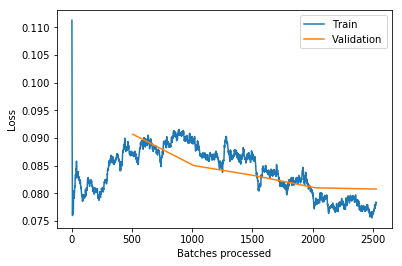

In [149]:
learn.recorder.plot_losses() # here val_loss doesn't increase and then decrease, don't know why?

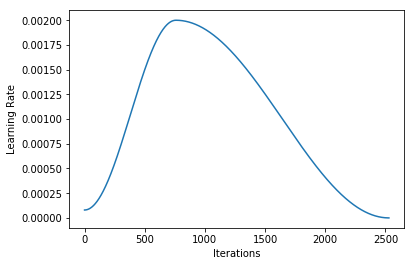

In [150]:
learn.recorder.plot_lr()

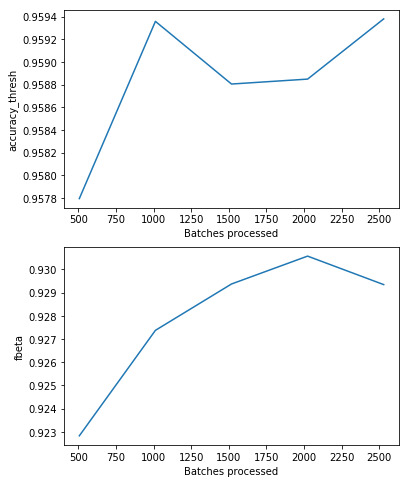

In [151]:
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-2-256-rs50')